<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/PWM_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Pulse Width Modulation - The Spectrum</h1></b>

Dr. Bingsen Wang

11/23/2023
</center>

#Python Code
The Python code illustrates the basic PWM spectrum by adding its dc and sinusoidal components.  

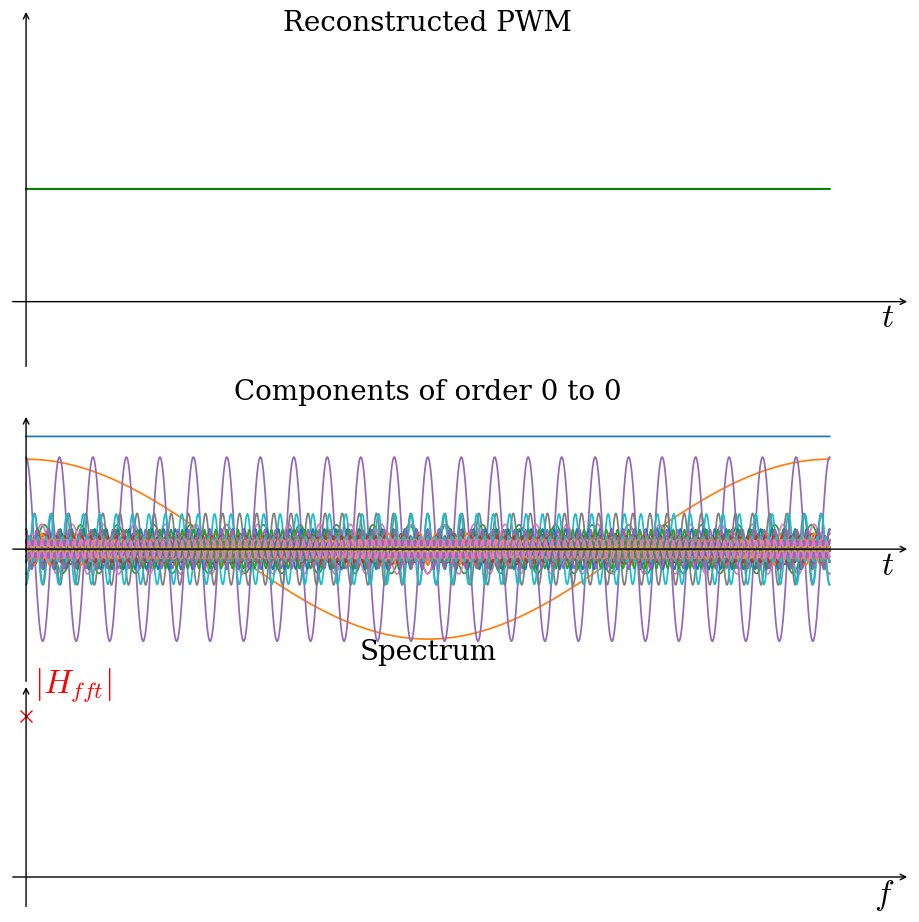

In [82]:
import matplotlib
from os import linesep
from numpy import linspace,cos,pi,sin,random,arccos,heaviside,fft,angle,abs
import matplotlib.pyplot as plt
from matplotlib import animation,rc
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#functions
def carr(f,t): #carrier
  return 1/pi*arccos(cos(2*pi*f*t))

def m(MI,f,theta,t): #modulation function
  return (MI*cos(2*pi*f*t + theta) + 1)/2

def h(ct,mt): #PWM switching function
  return heaviside(mt-ct,0)

def spectrum(xt): #spectrum - magnitude and angle
  xfft = fft.rfft(xt)
  xfft_angle = angle(xfft)
  xfft_mag = abs(xfft)/len(xt)*2
  xfft_mag[0]=xfft_mag[0]*0.5 #adjust the dc component
  return xfft_mag,xfft_angle

def yh(A,theta,f,n,t):
  return A*cos(2*pi*n*f*t + theta)

def y_sum(Xfft,f,nn,t): #sum of components, nn: # of harmonics
  yy=0
  for i in range(nn+1): #odd ac components, fundamental & harmonics
    yy = yy + yh(Xfft[0][i], Xfft[1][i], f, i, t)
  return yy

#parameters
Nf = 135 # number of frames
fm = 1 # modulation frequency
fc = 24 # carrier frequency
MI = 0.8 # modulation index
Np = 4096 # number of points for time series

#time series
t=linspace(0,1,Np)
ct = carr(fc,t) #carrier time-domain signal
mt = m(MI,1,0,t) #modulation function time series
ht = h(ct,mt) #pwm signal time series

#spectrum
fser = linspace(0,1,int(Np/2)+1)#frequency series
hfft = spectrum(ht)
# ht_rc = y_sum(hfft,fm,120,t)

#set up figures
fig = plt.figure(figsize=(9,9))
fig.tight_layout()
ax_frame = [[[0, 0.6, 1, .4], [-.02,1.1], [-.3,1.3]], #recon pwm
            [[0, 0.25,   1, .3], [-.02,1.1], [-.6,.6]], # components
            [[0, 0,   1, .25], [-.02,1.1], [-.1,0.6]], # spectrum - mag
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[['', '$t$'], ['', '$t$'],['$|H_{fft}|$','$f$']] #yx axes labels
clst=['g','b','r'] #colors of lines
ax_lst=[] #axis list or the list of subplots
lines = [] #array for all lines
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
  ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
  if k==0:
    line_rec = ax.plot([], [], clst[k], lw=1.5)[0] #reconstructed h(t)
  elif k==1:
    for kk in range(int(Np/2)):
      lines.append(ax.plot([], [], lw=1.25)[0]) #dc and
  else:
     line_spectr = ax.plot([], [], clst[k], ls='', marker='x',markersize=8)[0] #spectrum
  ax.text(xm-.02,0,ax_lbl[k][-1],size=24,va='top',ha='right') #x-axis label
  y_text=ax.text(0.01,ym,ax_lbl[k][0],size=24,va='center',color=clst[k]) #y label
ax_lst[0].text(0.5,ax_frame[0][2][1],'Reconstructed PWM',va='top',ha='center',size=20)
tx1=ax_lst[1].text(0.5,ax_frame[1][2][1]+.1,'',va='center',ha='center',size=20)
ax_lst[2].text(0.5,ax_frame[2][2][1]+0.1,'Spectrum',va='center',ha='center',size=20)
# animation function. This is called sequentially
def animate(i):
  tx1.set_text('Components of order 0 to '+str(i))
  line_rec.set_data(t,y_sum(hfft,fm,i,t))
  if i==0:
    lines[i].set_data(t,t*0+hfft[0][0])
  else:
    lines[i].set_data(t,yh(hfft[0][i],hfft[1][i],fm,i,t))
  line_spectr.set_data(fser[:i+1]*20,hfft[0][:i+1])
  return

anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"PWM_spectrum.mp4"
writervideo = animation.FFMpegWriter(fps=3)
anim.save(fn, writer=writervideo,dpi = 120)